In [86]:
#import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import os.path
import tensorflow as tf
from pathlib import Path
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                         Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN, LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D

In [87]:
#path
data = Path("Mask Datasets")

In [88]:
PNG_Path = list(data.glob(r"*/*.png"))

In [89]:
#label
PNG_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],PNG_Path))

In [90]:
PNG_Path_Series = pd.Series(PNG_Path, name="PNG").astype(str)
PNG_Labels_Series = pd.Series(PNG_Labels, name="CATEGORY")

In [91]:
#dataframe
Main_Data = pd.concat([PNG_Path_Series,PNG_Labels_Series], axis=1)

In [92]:
print(Main_Data)

                                               PNG               CATEGORY
0        Mask Datasets\mask_weared_incorrect\1.png  mask_weared_incorrect
1       Mask Datasets\mask_weared_incorrect\10.png  mask_weared_incorrect
2      Mask Datasets\mask_weared_incorrect\100.png  mask_weared_incorrect
3     Mask Datasets\mask_weared_incorrect\1000.png  mask_weared_incorrect
4     Mask Datasets\mask_weared_incorrect\1001.png  mask_weared_incorrect
...                                            ...                    ...
8977               Mask Datasets\with_mask\995.png              with_mask
8978               Mask Datasets\with_mask\996.png              with_mask
8979               Mask Datasets\with_mask\997.png              with_mask
8980               Mask Datasets\with_mask\998.png              with_mask
8981               Mask Datasets\with_mask\999.png              with_mask

[8982 rows x 2 columns]


In [93]:
print(Main_Data['CATEGORY'].value_counts())

mask_weared_incorrect    2994
without_mask             2994
with_mask                2994
Name: CATEGORY, dtype: int64


In [94]:
#shuffling
Main_Data = Main_Data.sample(frac=1).reset_index(drop=True)
print(Main_Data)

                                               PNG               CATEGORY
0              Mask Datasets\without_mask\2897.png           without_mask
1     Mask Datasets\mask_weared_incorrect\1836.png  mask_weared_incorrect
2               Mask Datasets\without_mask\678.png           without_mask
3               Mask Datasets\without_mask\705.png           without_mask
4              Mask Datasets\without_mask\1778.png           without_mask
...                                            ...                    ...
8977  Mask Datasets\mask_weared_incorrect\1656.png  mask_weared_incorrect
8978               Mask Datasets\with_mask\534.png              with_mask
8979           Mask Datasets\without_mask\1190.png           without_mask
8980              Mask Datasets\with_mask\1245.png              with_mask
8981              Mask Datasets\with_mask\1628.png              with_mask

[8982 rows x 2 columns]


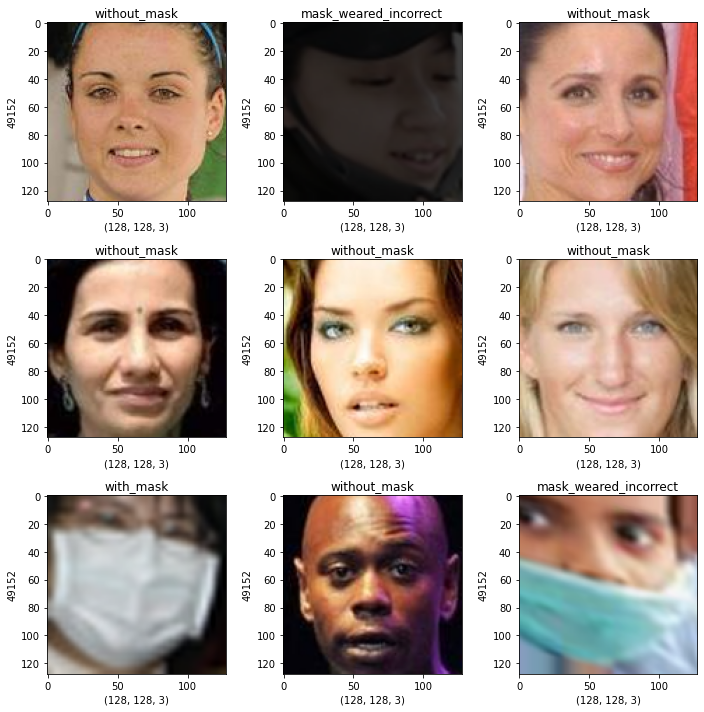

In [95]:
#Data Visualization
figure,axis = plt.subplots(nrows=3,ncols=3,figsize=(10,10))

for indexing,run_axes in enumerate(axis.flat):
    Reading_IMG = cv2.imread(Main_Data["PNG"][indexing])
    Transformation_IMG = cv2.cvtColor(Reading_IMG,cv2.COLOR_BGR2RGB)
        
    run_axes.set_xlabel(Transformation_IMG.shape)
    run_axes.set_ylabel(Transformation_IMG.size)
    run_axes.set_title(Main_Data["CATEGORY"][indexing])
    
    run_axes.imshow(Transformation_IMG)
    
plt.tight_layout()
plt.show()
    

In [96]:
#Splitting data
train_data, test_data = train_test_split(Main_Data, train_size = 0.9, shuffle = True, random_state = 42)

In [97]:
#Image generator
train_img_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=25,
                                        shear_range=0.5,
                                        zoom_range=0.5,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode="nearest",
                                        validation_split=0.1)
test_img_generator = ImageDataGenerator(rescale=1./255)

In [98]:
#split data using imagedatagenerator
train_img_set = train_img_generator.flow_from_dataframe(dataframe=train_data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       subset="training")

validation_img_set = train_img_generator.flow_from_dataframe(dataframe=train_data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       subset="validation")

test_img_set = test_img_generator.flow_from_dataframe(dataframe=test_data,
                                                       x_col="PNG",
                                                       y_col="CATEGORY",
                                                       color_mode="rgb",
                                                       class_mode="categorical",
                                                       target_size=(128,128),
                                                       shuffle=False)

Found 7275 validated image filenames belonging to 3 classes.
Found 808 validated image filenames belonging to 3 classes.
Found 899 validated image filenames belonging to 3 classes.


In [99]:
#Model

Model = Sequential()

Model.add(Conv2D(32,(3,3),activation="relu",input_shape=(128,128,3)))
Model.add(BatchNormalization())
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2)))

Model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
Model.add(Dropout(0.3))
Model.add(MaxPooling2D((2,2)))

Model.add(Flatten())
Model.add(Dense(256,activation="relu"))
Model.add(Dropout(0.5))

Model.add(Dense(3,activation="softmax"))

In [100]:
Early_Stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [101]:
Model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [102]:
print(Model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_2 (Batc  (None, 126, 126, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 63, 63, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 64)      

In [103]:
cnn = Model.fit(train_img_set, validation_data = validation_img_set, epochs=50)

Epoch 1/50
228/228 [==============================] - 282s 1s/step - loss: 0.6405 - accuracy: 0.7522 - val_loss: 0.9877 - val_accuracy: 0.6460
Epoch 2/50
228/228 [==============================] - 275s 1s/step - loss: 0.4689 - accuracy: 0.8227 - val_loss: 0.7550 - val_accuracy: 0.8391
Epoch 3/50
228/228 [==============================] - 274s 1s/step - loss: 0.3892 - accuracy: 0.8591 - val_loss: 0.4526 - val_accuracy: 0.8502
Epoch 4/50
228/228 [==============================] - 276s 1s/step - loss: 0.3658 - accuracy: 0.8712 - val_loss: 0.4406 - val_accuracy: 0.8960
Epoch 5/50
228/228 [==============================] - 273s 1s/step - loss: 0.3193 - accuracy: 0.8851 - val_loss: 0.3908 - val_accuracy: 0.8589
Epoch 6/50
228/228 [==============================] - 271s 1s/step - loss: 0.2959 - accuracy: 0.8937 - val_loss: 0.4841 - val_accuracy: 0.8502
Epoch 7/50
228/228 [==============================] - 272s 1s/step - loss: 0.2807 - accuracy: 0.9013 - val_loss: 0.4277 - val_accuracy: 0.8973

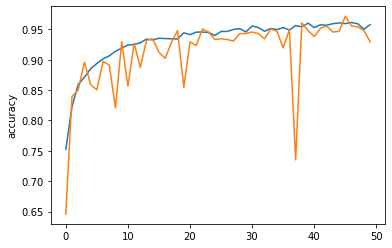

In [105]:
#accuracy
plt.plot(cnn.history["accuracy"])
plt.plot(cnn.history["val_accuracy"])
plt.ylabel("accuracy")
plt.show()

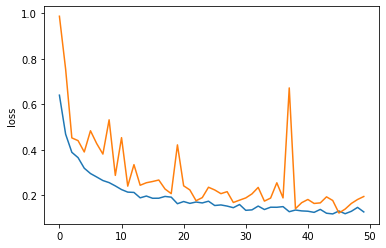

In [106]:
#loss
plt.plot(cnn.history["loss"])
plt.plot(cnn.history["val_loss"])
plt.ylabel("loss")
plt.show()

In [117]:
#check accuracy and loss
print("Training Accuracy:"), print(cnn.history['accuracy'][-1])
print("Testing Accuracy:"), print (cnn.history['val_accuracy'][-1])

Training Accuracy:
0.9578006863594055
Testing Accuracy:
0.9294554591178894


(None, None)

In [108]:
#predict
model_result = Model.evaluate(test_img_set)
print("loss : " + "%.4f" % model_result[0])
print("accuracy : " + "%.4f" % model_result[1])

29/29 [==============================] - 8s 272ms/step - loss: 0.1333 - accuracy: 0.9544
loss : 0.1333
accuracy : 0.9544


In [114]:
prediction_number = Model.predict(test_img_set)
prediction = prediction_number.argmax(axis=-1)
print(prediction[0:10])

29/29 [==============================] - 8s 284ms/step
[2 0 0 0 0 2 1 0 0 0]


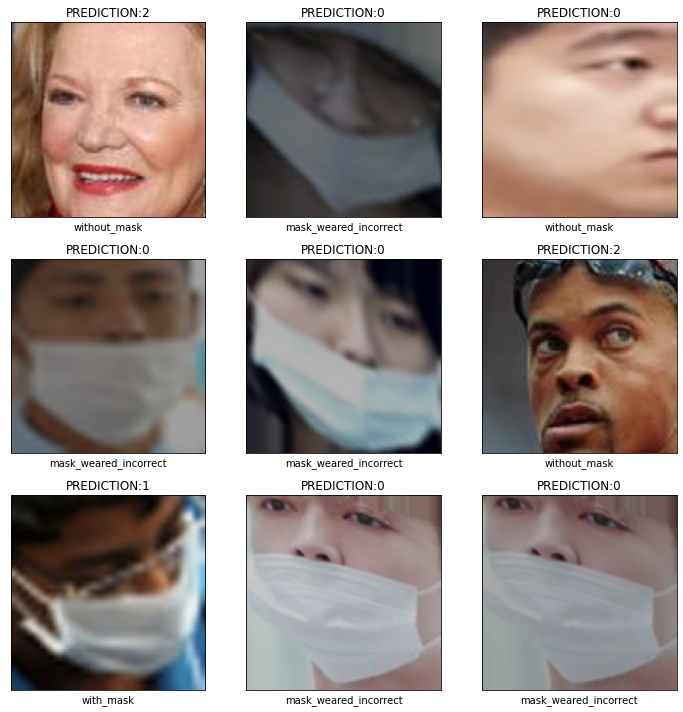

In [115]:
fig, axes = plt.subplots(nrows=3,
                         ncols=3,
                         figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_data["PNG"].iloc[i]))
    ax.set_title(f"PREDICTION:{prediction[i]}")
    ax.set_xlabel(test_data["CATEGORY"].iloc[i])
plt.tight_layout()
plt.show()